In [1]:
# device = 'K0303'
# active_power_variable = 'active_power'
path_base_r_string = r'D:\OneDrive - CELSIA S.A E.S.P'

%load_ext autoreload
%autoreload 2
import warnings
# warnings.filterwarnings("ignore")

In [2]:
# this cell enables project path relative imports
import sys
from pathlib import Path
path_base = Path(path_base_r_string)
project_path = path_base / 'Proyectos' / 'Eficiencia_Energetica' / 'Homecenter' / 'medicion_temporal_cargill'
sys.path.append(str(project_path))

In [3]:
# import all your modules here
import json
import pandas as pd
import numpy as np
import config as cfg

from library_ubidots_v2 import Ubidots as ubi

In [4]:
# most store-level devices are correctly assigned to the homecenter organization
df_devices_org = ubi.get_available_devices_v2(label='homecenter', level='organization', page_size=1000)

# Devices belonging to the homecenter-sedes device group must be filtered out
# as they are intended for the client-side dashboard
df_devices_org = df_devices_org[~df_devices_org['device_name'].str.startswith('HC - ')]


# to get the missing devices we must request all the devices from the account
df_devices_acc = ubi.get_available_devices_v2(label=None, level='account', page_size=1000)

# not all stores are properly assigned to the organization
df_stores = df_devices_acc[df_devices_acc['device_name'].str.startswith('HC - ')]

# then filter out the missing devices
store_name_substrings = [
    'BAQ - ', # Barranquilla
    'Tintal - ', # Tintal
    'Bello - ', # Bello
    'San Juan - ', # San Juan
]

lst_df = []
for sub_str in store_name_substrings:
    is_missing = (df_devices_acc['device_name'].str.startswith(sub_str))
    lst_df.append(df_devices_acc[is_missing])

df_missing_devices = pd.concat(lst_df)

# finally we combine to get a complete set of store-level devices
df_devices = pd.concat([df_devices_org, df_missing_devices])

In [12]:
DEVICE_IDS_TO_REQUEST = list(df_stores['device_id'])
df_vars_stores = ubi.get_available_variables(DEVICE_IDS_TO_REQUEST)
df_vars_stores['device_name'] = df_vars_stores['device_id'].map(dict(zip(df_stores['device_id'], df_stores['device_name'])))

In [13]:
df_vars_stores

,variable_id,variable_label,device_id,device_name
0,628faef6cfb70c4433267ecf,consumo-domingos-y-festivos,623c9c3ddc4fea000cf155b1,HC - Cali norte
1,628faea21ecd6f65befcba6f,consumo-sabado,623c9c3ddc4fea000cf155b1,HC - Cali norte
2,628fae80d245925401c4b0c5,consumo-semana,623c9c3ddc4fea000cf155b1,HC - Cali norte
3,628fadf64e96714c0783d55c,consumo-promedio-por-dia,623c9c3ddc4fea000cf155b1,HC - Cali norte
4,628faa1e9fa0a160818e0d18,pa-equipos-de-climatizacion,623c9c3ddc4fea000cf155b1,HC - Cali norte
...,...,...,...,...
473,61fd7ecb52fc52000a6d6959,ac-tension-l3,61fbfb883ac637252222607e,HC - San Juan
474,61fd7eb8a28d07000a348e89,ac-tension-l2,61fbfb883ac637252222607e,HC - San Juan
475,61fd7ea3657523000ca7b5d2,ac-tension-l1,61fbfb883ac637252222607e,HC - San Juan
476,61fd21dbb458490a50a8b1b3,ea-iluminacion-patio-constructor,61fbfb883ac637252222607e,HC - San Juan


In [14]:
df_vars_stores['bool'] = True
df_vars_stores_wide = (
    df_vars_stores
    .pivot(
        index='variable_label',
        columns='device_name',
        values='bool'
    )
    .replace({np.nan:0})
)

In [ ]:
df_vars_stores

In [15]:
DEVICE_IDS_TO_REQUEST = list(df_devices['device_id'])
df_vars_dev = ubi.get_available_variables(DEVICE_IDS_TO_REQUEST)
df_vars_dev['device_name'] = df_vars_dev['device_id'].map(dict(zip(df_devices['device_id'], df_devices['device_name'])))

In [52]:
df_map_aa_ilu = pd.read_excel("ubidots_device_map.xlsx", sheet_name='AA-ILU', header=None)
df_vars_aa_ilu = df_vars_dev[df_vars_dev['device_name'].isin(list(df_map_aa_ilu[0]))].copy()

df_vars_aa_ilu['type'] = df_vars_aa_ilu['device_name'].map(dict(zip(df_map_aa_ilu[0], df_map_aa_ilu[1])))

is_split = df_vars_aa_ilu['variable_label'].str.startswith(('c1','c2','c3'))
is_misconf = df_vars_aa_ilu['variable_label'].str.startswith('new-')

df_vars_split = df_vars_aa_ilu[is_split].copy()
df_vars_single = df_vars_aa_ilu[(~is_split & ~is_misconf)].copy()
df_vars_misconf = df_vars_aa_ilu[is_misconf].copy()


split_devices = set(df_vars_split['device_name'])
single_devices = set(df_vars_single['device_name'])

In [53]:
df_vars_aa_ilu

,variable_id,variable_label,device_id,device_name,type
16,623d2ba3adcd7008dc3a5a3b,energia-reactiva-inductiva,623d292cdc4fea1a6acd1c92,Cali Norte - Iluminación Patio Constructor,ILU
17,623d2ba3adcd7008dc3a5a3a,energia-activa,623d292cdc4fea1a6acd1c92,Cali Norte - Iluminación Patio Constructor,ILU
18,623d2ba3adcd7008dc3a5a39,factor-de-potencia,623d292cdc4fea1a6acd1c92,Cali Norte - Iluminación Patio Constructor,ILU
19,623d2ba3adcd7008dc3a5a38,corriente-total,623d292cdc4fea1a6acd1c92,Cali Norte - Iluminación Patio Constructor,ILU
20,623d2ba3adcd7008dc3a5a37,corriente-l3,623d292cdc4fea1a6acd1c92,Cali Norte - Iluminación Patio Constructor,ILU
...,...,...,...,...,...
2373,61ef1e3e6b081c00865aa9ef,potencia-reactiva-instantanea-total,61ef1a16cf403e50d400cfe3,San Juan - Iluminación Patio Constructor,ILU
2374,61ef1e3e6b081c00865aa9ee,potencia-activa-instantanea-total,61ef1a16cf403e50d400cfe3,San Juan - Iluminación Patio Constructor,ILU
2375,61ef1e3e6b081c00865aa9ed,energia-reactiva-inductiva-acumulada,61ef1a16cf403e50d400cfe3,San Juan - Iluminación Patio Constructor,ILU
2376,61ef1e3e6b081c00865aa9ec,energia-reactiva-capacitiva-acumulada,61ef1a16cf403e50d400cfe3,San Juan - Iluminación Patio Constructor,ILU


In [50]:
df_vars_stores['bool'] = True
df_vars_stores_wide = (
    df_vars_stores
    .pivot(
        index='variable_label',
        columns='device_name',
        values='bool'
    )
    .replace({np.nan:0})
)


df_vars_split['bool'] = True
df_vars_split_wide = (
    df_vars_split
    .pivot(
        index='variable_label',
        columns='device_name',
        values='bool'
    )
    .replace({np.nan:0})
)

df_vars_single['bool'] = True
df_vars_single_wide = (
    df_vars_single
    .pivot(
        index='variable_label',
        columns='device_name',
        values='bool'
    )
    .replace({np.nan:0})
)

df_vars_misconf['bool'] = True
df_vars_misconf_wide = (
    df_vars_misconf
    .pivot(
        index='variable_label',
        columns='device_name',
        values='bool'
    )
    .replace({np.nan:0})
)

In [54]:
energy_vars_single_aa_ilu = [
    'ener',
    'energia-activa',
    'energia-activa-acumulada',
    'energia-activa-calculada',
]


In [55]:
df_vars_single

,variable_id,variable_label,device_id,device_name,type
16,623d2ba3adcd7008dc3a5a3b,energia-reactiva-inductiva,623d292cdc4fea1a6acd1c92,Cali Norte - Iluminación Patio Constructor,ILU
17,623d2ba3adcd7008dc3a5a3a,energia-activa,623d292cdc4fea1a6acd1c92,Cali Norte - Iluminación Patio Constructor,ILU
18,623d2ba3adcd7008dc3a5a39,factor-de-potencia,623d292cdc4fea1a6acd1c92,Cali Norte - Iluminación Patio Constructor,ILU
19,623d2ba3adcd7008dc3a5a38,corriente-total,623d292cdc4fea1a6acd1c92,Cali Norte - Iluminación Patio Constructor,ILU
20,623d2ba3adcd7008dc3a5a37,corriente-l3,623d292cdc4fea1a6acd1c92,Cali Norte - Iluminación Patio Constructor,ILU
...,...,...,...,...,...
2373,61ef1e3e6b081c00865aa9ef,potencia-reactiva-instantanea-total,61ef1a16cf403e50d400cfe3,San Juan - Iluminación Patio Constructor,ILU
2374,61ef1e3e6b081c00865aa9ee,potencia-activa-instantanea-total,61ef1a16cf403e50d400cfe3,San Juan - Iluminación Patio Constructor,ILU
2375,61ef1e3e6b081c00865aa9ed,energia-reactiva-inductiva-acumulada,61ef1a16cf403e50d400cfe3,San Juan - Iluminación Patio Constructor,ILU
2376,61ef1e3e6b081c00865aa9ec,energia-reactiva-capacitiva-acumulada,61ef1a16cf403e50d400cfe3,San Juan - Iluminación Patio Constructor,ILU


In [58]:
VAR_IDS_TO_REQUEST = df_vars_single.loc[df_vars_single['variable_label'].isin(energy_vars_single_aa_ilu), 'variable_id']
VAR_ID_TO_LABEL = dict(zip(df_vars_single['variable_id'], df_vars_single['variable_label']))

In [59]:
CHUNK_SIZE = 30
DATE_INTERVAL_REQUEST = {'start': '2022-05-01', 'end': '2022-10-31'}

df = None
lst_responses = []
for idx in range(0, ubi.ceildiv(len(VAR_IDS_TO_REQUEST), CHUNK_SIZE)):
    idx_start = idx * CHUNK_SIZE
    idx_end = (idx + 1) * CHUNK_SIZE
    id_request_subset = VAR_IDS_TO_REQUEST[idx_start:idx_end]

    response = ubi.make_request(
        id_request_subset, 
        DATE_INTERVAL_REQUEST, 
    )

    lst_responses.append(response)

df = ubi.parse_response(lst_responses, VAR_ID_TO_LABEL)
pd.to_pickle(df, project_path / "dataframe.pkl")

In [60]:
df

,value,variable,device,device_name
datetime,,,,
2022-10-27 12:00:00-05:00,84.5,energia-activa,cali-norte---iluminacion-patio-constructor,Cali Norte - Iluminación Patio Constructor
2022-10-27 10:00:00-05:00,42.25,energia-activa,cali-norte---iluminacion-patio-constructor,Cali Norte - Iluminación Patio Constructor
2022-10-27 09:00:00-05:00,8.45,energia-activa,cali-norte---iluminacion-patio-constructor,Cali Norte - Iluminación Patio Constructor
2022-10-27 08:00:00-05:00,51.11,energia-activa,cali-norte---iluminacion-patio-constructor,Cali Norte - Iluminación Patio Constructor
2022-10-27 06:00:00-05:00,8.77,energia-activa,cali-norte---iluminacion-patio-constructor,Cali Norte - Iluminación Patio Constructor
...,...,...,...,...
2022-05-01 06:00:00-05:00,159713.0,energia-activa-acumulada,san-juan---iluminacion-patio-constructor,San Juan - Iluminación Patio Constructor
2022-05-01 04:30:00-05:00,159705.0,energia-activa-acumulada,san-juan---iluminacion-patio-constructor,San Juan - Iluminación Patio Constructor
2022-05-01 04:15:00-05:00,159704.0,energia-activa-acumulada,san-juan---iluminacion-patio-constructor,San Juan - Iluminación Patio Constructor


In [61]:
set(df.loc[df['device'].str.startswith('bello'), 'device'])

{'bello---aires-acondicionados',
 'bello---iluminacion-patio-constructor',
 'bello---iluminacion-principal',
 'bello-mini-splits'}

In [62]:
df_plot = df[df['device'] == 'bello---iluminacion-patio-constructor']

<AxesSubplot:xlabel='datetime'>

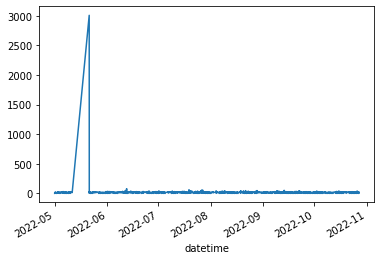

In [66]:
df_plot['value'].plot()

In [67]:
set(df.variable)

{'ener',
 'energia-activa',
 'energia-activa-acumulada',
 'energia-activa-calculada'}

In [ ]:
energy_var_rename = {
    'ener':'energia-activa-acumulada',
    'energia-activa':'energia-activa',
    'energia-activa-acumulada':'energia-activa-acumulada',
    'energia-activa-calculada':'energia-activa'
}

In [ ]:
df = df['variable'].map()

In [75]:
df_grouped_vars = df.groupby(['variable', 'device', 'device_name']).count().reset_index()

In [71]:
from matplotlib import pyplot as plt

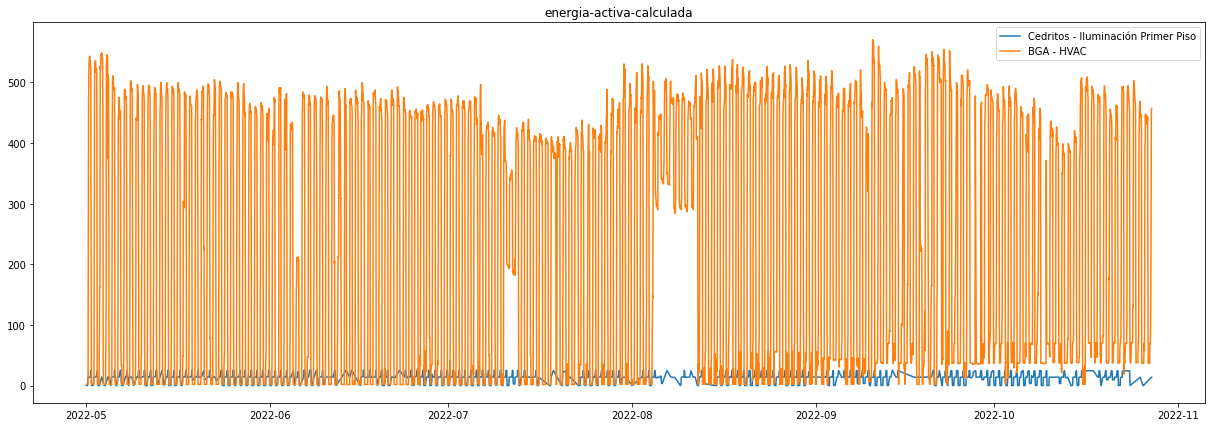

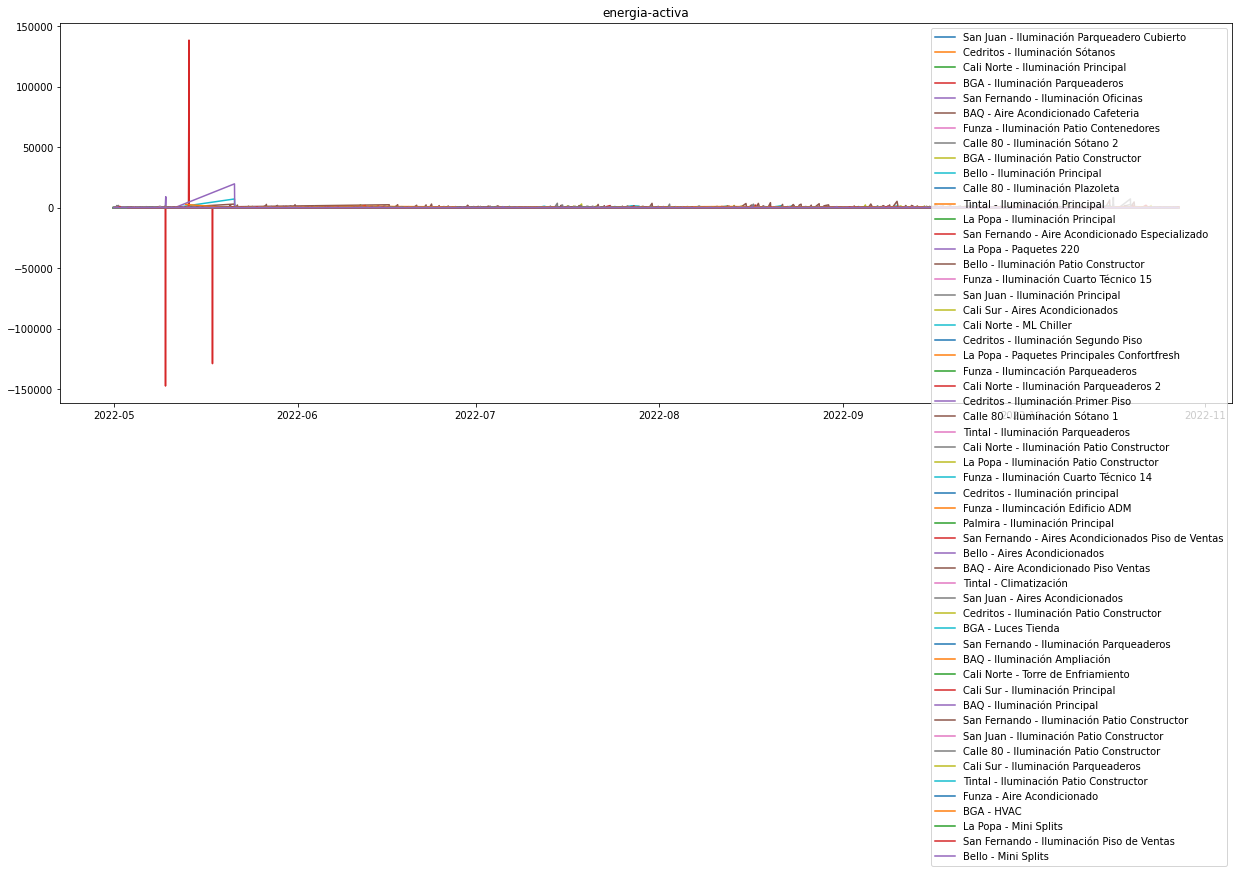

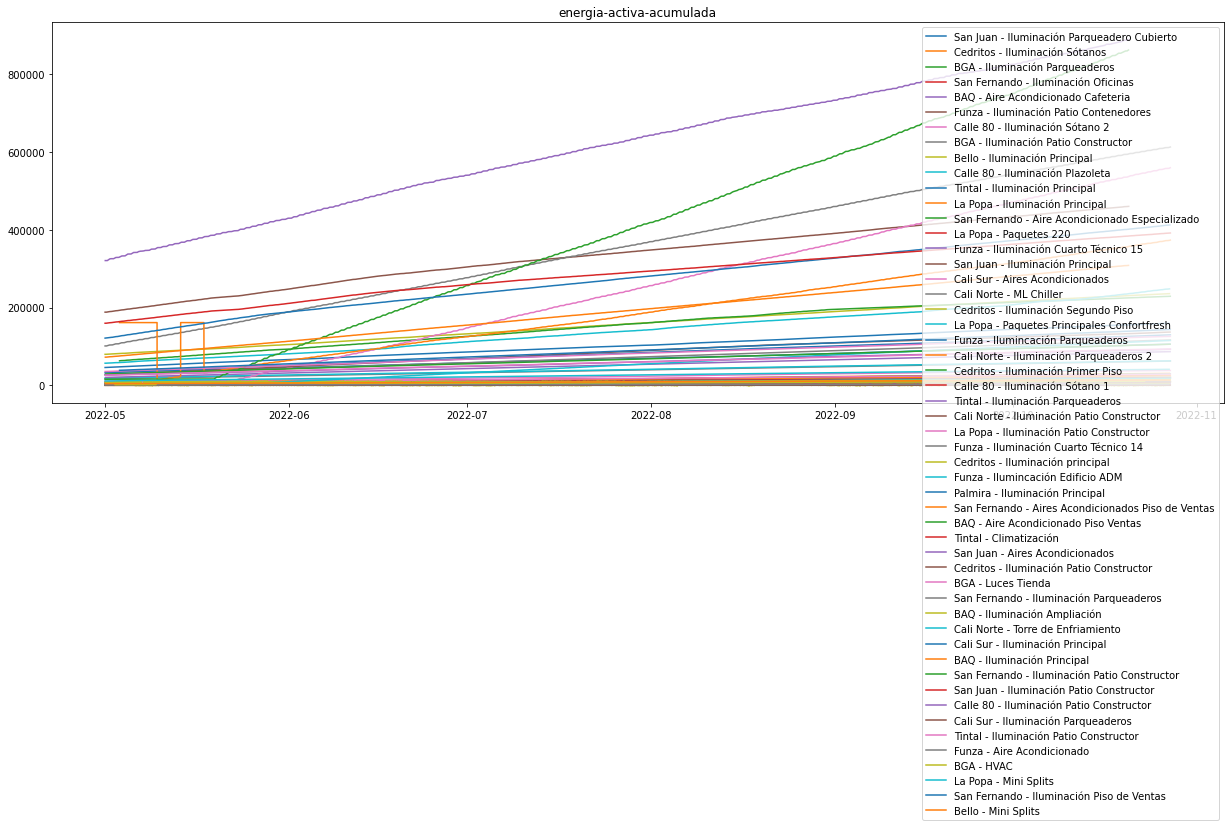

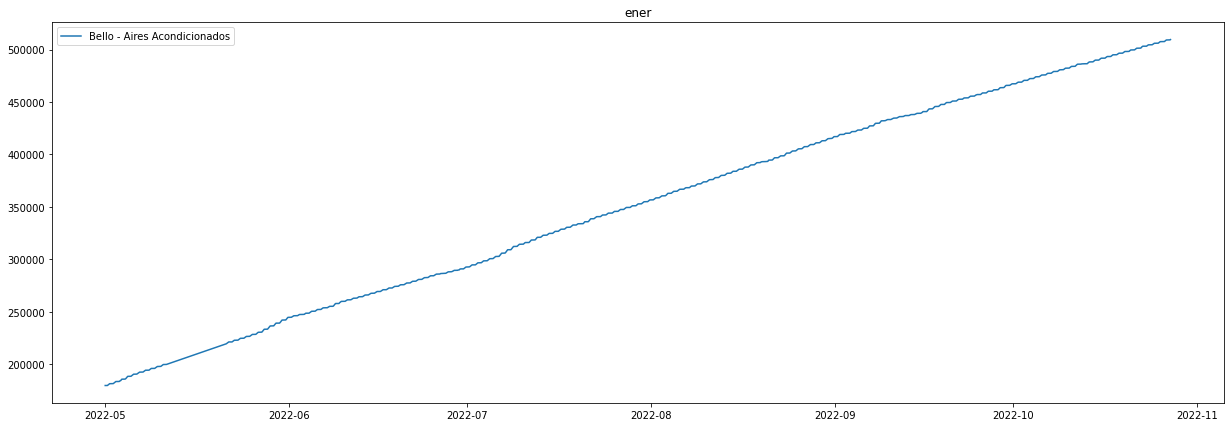

In [76]:
for variable in set(df.variable):
    df_sub_var = df.query('variable == @variable')

    plt.figure(figsize=(21,7))

    for device_name in set(df_sub_var['device_name']):
        df_sub_var_dev = df_sub_var.query('device_name == @device_name')

        plt.plot(df_sub_var_dev['value'], label=device_name)
    
    plt.title(variable)
    plt.legend()
    plt.show()



In [ ]:
# df_coords = Report.get_coords_dataframe(list(df_devices['id']))
# pd.to_pickle(df_coords, "data_coordinates.pkl")